# scaredy rat uses raw data from EthoVision to analyze behavior over time. 

#### To restart, go to Kernel > Restart & Run All
Known possible issues:
 - there won't be data for the 12th tone due to indexing issues. fix tbd.
 - in the animal_read function, the indexes are specific to the ethovision output setup. sometimes there are other rows in the header, so the numbers will have to be changed. if that function throws an error, this may be the issue. for reference, the animal ID is row 33 on the excel file, so the corresponding index is **df.iloc[31]**. **skipfooter** just needs to be set to a value after the row # for animal. the headers are on row 35, so **skiprows=34**.

for others, email me at li.anna@husky.neu.edu

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import xlsxwriter
from openpyxl import load_workbook
import math
import time

In [3]:
def animal_read(filename,sheet):
    '''
    Returns corresponding animals for sheets
    Reads data into dataframe with long header removed.
    Uses correct labels as column labels.
    Uses time as row indexes.
    '''
    filepath = inpath + '\\' + filename
    df = pd.read_excel(filepath,sheetname=sheet,skip_footer=34,index_col=0)
    animal = df.iloc[31][0]
    print(filename + " " + sheet + " is " + animal)
    
    df = pd.read_excel(filepath,sheetname=sheet,skiprows=34,index_col=0,headers=0)
    df = df[1:]
    df.replace(to_replace='-',value=0,inplace=True)
    return(animal,df)

In [4]:
def find_tones(df):
    '''
    Creates dictionary of each tone. Values are
    dataframes for times at which each tone == 1.
    '''
    tones = {}
    i = 1
    while i <= 12: # number of tones
        num = str(i)
        label = 'Tone ' + num
        tone = pd.DataFrame(df[df[label] == 1])
        tones[i] = tone
        i += 1
    return(tones)

In [5]:
def find_pretones(df):
    '''
    Creates dictionary of each pretone. Values
    are dataframes for 30s before tone == 1
    '''
    pretones = {}
    i = 1
    while i<= 12:
        num = str(i)
        label = 'Tone ' + num #Column label for each tone
        
        tone = df[df[label] == 1] #Tone dataframe
        tonestart = tone.iloc[0] #Time for tone start
        
        starttime = math.floor(tonestart['Recording time']-30) #Time for pretone start
        endtime = math.floor(tonestart['Recording time']) #Time for pretone end
        itime = df.index.get_loc(starttime,method='bfill') #Index for pretone start
        etime = df.index.get_loc(endtime,method='bfill') #Index for pretone end
        
        pretone = df.iloc[itime:etime] #df for pretone
        pretones[i] = pretone #dictionary for all pretones
        i += 1
    return(pretones)

In [6]:
def find_shock_responses(df):
    '''
    Creates dictionary of each shock response. Values
    are dataframes for 5s after tone == 1
    '''
    sresponses = {}
    i = 1
    while i<= 11:
        num = str(i)
        label = 'Tone ' + num #Column label for each tone
        
        tone = df[df[label] == 1] #Tone dataframe
        toneend = tone.iloc[-1] #Time for tone end
        
        starttime = math.floor(toneend['Recording time']) #Time for sresponse start
        endtime = math.floor(toneend['Recording time'] + 5) #Time for sresponse end
        itime = df.index.get_loc(starttime,method='bfill') #Index for sresponse start
        etime = df.index.get_loc(endtime,method='bfill') #Index for sresponse end
        
        sresponse = df.iloc[itime:etime] #df for sresponse
        sresponses[i] = sresponse #dictionary for all sresponse
        i += 1
    return(sresponses)

In [7]:
def find_postshocks(df):
    '''
    Creates dictionary of each postshock. Values
    are dataframes for 5s after tone == 1
    '''
    pshocks = {}
    i = 1
    while i<= 11:
        num = str(i)
        label = 'Tone ' + num #Column label for each tone
        
        tone = df[df[label] == 1] #Tone dataframe
        toneend = tone.iloc[-1] #Time for tone end
        
        starttime = math.floor(toneend['Recording time'] + 5) #Time for pshock start
        endtime = math.floor(toneend['Recording time'] + 35) #Time for pshock end
        itime = df.index.get_loc(starttime,method='bfill') #Index for pshock start
        etime = df.index.get_loc(endtime,method='bfill') #Index for pshock end
        
        pshock = df.iloc[itime:etime] #df for pshock
        pshocks[i] = pshock #dictionary for all sresponse
        i += 1
    return(pshocks)

In [8]:
def get_total_dists(datadict):
    i = 1
    while i <= 12:
        epoch = datadict[i]
        dist = epoch['Distance moved']
        total = dist.sum()
        print()

In [9]:
def get_means(datadict,timebin):
    meanlist = []
    i = 1
    while i <= 11:
        epoch = datadict[i]
        vels = epoch['Velocity']
        mean = round(vels.mean(),3)
        meanlist.append(mean)
        i += 1
    means = pd.DataFrame(meanlist,columns=[timebin + ' Mean Velocity'])
    means.index = np.arange(1, len(means) + 1)
    return(means)

In [10]:
def get_meds(datadict,timebin):
    medlist = []
    i = 1
    while i <= 11:
        epoch = datadict[i]
        vels = epoch['Velocity']
        med = round(vels.median(),3)
        medlist.append(med)
        i += 1
    meds = pd.DataFrame(medlist,columns=[timebin + ' Median Velocity'])
    meds.index = np.arange(1, len(meds) + 1)
    return(meds)

In [11]:
def get_vels(df):
    '''
    Creates data of all velocities from
    original dataframe for plotting.
    '''
    tonevels = {}
    i = 1
    while i <= 12: # number of tones
        vels = []
        num = str(i)
        label = 'Tone ' + num
        tone = pd.DataFrame(df[df[label] == 1])
        vels.append(tone['Velocity'])
        tonevels[i] = vels
        i += 1
    return(tonevels)

## Change variables in this cell only

In [13]:
## Be sure to put r before the path
inpath = r'C:\Users\Anna\Documents\Shansky Lab\Mindlin\Mindlin FC Raw Data'
## Make sure the outpath folder exists already.
## The file does not need to exist; it will be created.
outpath = r'C:\Users\Anna\Documents\Shansky Lab\BRF Darting\scaredy rat results'
filename = 'Raw data-Mindlin Project Fear Conditioning-Trial    12 (1).xlsx' ## include .xlsx
sheetname = 'Track-Arena 1-Subject 1'

## These are function calls
#### Take a while to run due to size of data sheet

In [14]:
ID,anim = animal_read(filename,sheetname)

tones = find_tones(anim)
pretones = find_pretones(anim)
shocks = find_shock_responses(anim)
pshocks = find_postshocks(anim)

tmeans = get_means(tones,'Tone')
ptmeans = get_means(pretones,'Pre-tone')
smeans = get_means(shocks,'Shock')
pshockmeans = get_means(pshocks,'Post-shock')
allmeans = pd.concat([tmeans, ptmeans, smeans, pshockmeans],axis=1)

tmeds = get_meds(tones,'Tone')
ptmeds = get_meds(pretones,'Pre-tone')
smeds = get_meds(shocks,'Shock')
pshockmeds = get_meds(pshocks,'Post-shock')
allmeds = pd.concat([tmeds, ptmeds, smeds, pshockmeds],axis=1)

Raw data-Mindlin Project Fear Conditioning-Trial    12 (1).xlsx Track-Arena 1-Subject 1 is JF13


## Output data and figures will be under this cell
#### Figures will also be saved

In [43]:
display(allmeans)
display(allmeds)

,Tone Mean Velocity,Pre-tone Mean Velocity,Shock Mean Velocity,Post-shock Mean Velocity
1,1.690,2.652,2.222,2.437
2,2.947,2.972,1.136,2.800
3,3.148,2.348,6.160,3.650
4,2.807,1.686,0.960,3.334
5,3.363,0.734,1.084,3.567
6,1.064,2.170,8.261,4.027
7,1.763,2.460,5.403,1.182
8,0.328,0.073,7.897,1.202
9,0.437,0.744,5.814,1.573
10,1.169,0.520,9.107,1.654


,Tone Median Velocity,Pre-tone Median Velocity,Shock Median Velocity,Post-shock Median Velocity
1,0.881,1.609,1.089,1.521
2,1.896,1.813,0.869,2.225
3,1.667,1.341,4.505,2.709
4,1.782,0.929,0.345,1.690
5,2.056,0.209,0.802,2.204
6,0.427,1.014,7.015,1.856
7,0.741,1.369,1.316,0.277
8,0.069,0.023,1.275,0.464
9,0.226,0.406,2.024,0.583
10,0.156,0.331,4.238,0.621


## This cell saves the mean/med velocities

In [16]:
## Saves the data to a file named with current date.
i = time.strftime("%m.%d.%Y")
outfile = outpath + '\\scaredy-rat-' + ID + '-' + i + '.xlsx'

writer = pd.ExcelWriter(outfile, engine='xlsxwriter')
allmeans.to_excel(writer)
allmeds.to_excel(writer,startrow=13)

writer.save()

#### future implementations:
 - _stupid sheet overwriting issue!!_
 - stuff noted in "known issues"
 - conditional on whether or not data for last one is present
 - findpeaks_cwt maybe (from signal)
 - nested functions

# Test section
### (Code that may or may not work yet)

In [17]:
def test_distr(veldict):
    i = 1
    f, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(15,5))
    while i <= 6:
        leg = 'Tone ' + str(i)
        data = pd.DataFrame(veldict[i])
        sns.distplot(data,hist=False,axlabel='velocity (cm/s)',label=leg,ax=ax1)
        i += 1
    while i > 6 and i<= 12:
        leg = 'Tone ' + str(i)
        data = veldict[i]
        sns.distplot(data,hist=False,axlabel='velocity (cm/s)',label=leg,ax=ax2)
        i += 1
    return(f)

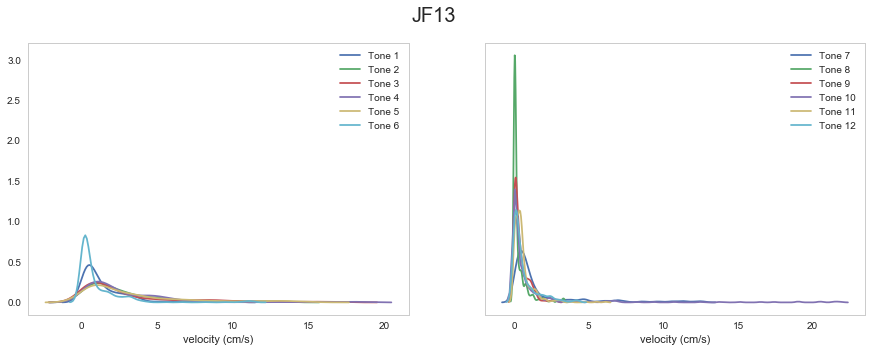

In [18]:
tvels = get_vels(anim)
test_distr(tvels)
plt.suptitle(ID, fontsize=20)
plt.show()

In [41]:
def plot_vel_distr(veldict):
    i = 1
    f = plt.figure(figsize=(15,5))
    sns.set_style('whitegrid',{'axes.grid' : False})
    
    ax1 = f.add_subplot(1,2,1)
    while i <= 6:
        leg = 'Tone ' + str(i)
        data = veldict[i]
        sns.distplot(data,hist=Tru1e,kde=False,axlabel='velocity (cm/s)',label=leg,ax=ax1)
        i += 1
    ax1.legend()
    
    ax2 = f.add_subplot(1,2,2,sharey=ax1,sharex=ax1)
    while i > 6 and i<= 12:
        leg = 'Tone ' + str(i)
        data = veldict[i]
        sns.distplot(data,hist=True,kde=False,axlabel='velocity (cm/s)',label=leg,ax=ax2)
        i += 1
    ax2.legend()
    
    return(f)

In [ ]:
tvels = get_vels(anim)
plot_vel_distr(tvels)
plt.suptitle(ID, fontsize=20)
## Saves figures to same folder named by animal
outimg = outpath + '\\' + ID + '-vel-dist.tiff'
plt.savefig(outimg,dpi=300)
plt.show()